# Homework (15 points)

In this homework we train Sound Event Detection model.

Dataset: https://disk.yandex.ru/d/NRpDIp4jg2ODqg

In [ ]:
# Run this whole cell once (it will restart the kernel automatically)
import os, subprocess, sys

try:
    conda_base = subprocess.check_output(["conda", "info", "--base"]).decode().strip()
except Exception as e:
    raise RuntimeError("Failed to find conda base. Are you running inside a conda env?") from e

conda_lib = os.path.join(conda_base, "lib")
old = os.environ.get("LD_LIBRARY_PATH", "")
os.environ["LD_LIBRARY_PATH"] = conda_lib + (":" + old if old else "")
print("Prepended to LD_LIBRARY_PATH:", conda_lib)

# Re-exec the current Python to pick up the new env (this restarts the kernel)
os.execv(sys.executable, [sys.executable] + sys.argv)


In [ ]:
# recommended: use conda (or mamba) to install newer libstdc++ and related runtime libs
!conda install -y -c conda-forge libstdcxx-ng libgcc-ng
# or, if you have mamba:
# mamba install -y -c conda-forge libstdcxx-ng libgcc-ng


In [ ]:
!pip install dataset

In [3]:
# install mamba to speed up dependency solving (only needs to be done once)
!conda install -y mamba -n base -c conda-forge

# then use mamba to install matching packages
!mamba install -y pytorch torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia


import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

# implementation of Dataset for given data|
import dataset

from IPython.display import clear_output

%matplotlib inline

done
Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::pyopenssl==23.2.0=pyhd8ed1ab_1
  - conda-forge/linux-64::pycosat==0.6.6=py311h459d7ec_0
  - conda-forge/linux-64::jsonpointer==2.4=py311h38be061_3
  - conda-forge/noarch::jsonpatch==1.33=pyhd8ed1ab_0
  - conda-forge/noarch::platformdirs==3.11.0=pyhd8ed1ab_0
  - conda-forge/noarch::conda-package-streaming==0.9.0=pyhd8ed1ab_0
  - conda-forge/noarch::packaging==23.2=pyhd8ed1ab_0
  - conda-forge/noarch::truststore==0.8.0=pyhd8ed1ab_0
  - conda-forge/noarch::requests==2.31.0=pyhd8ed1ab_0
  - conda-forge/linux-64::jupyter_core==5.4.0=py311h38be061_0
  - conda-forge/noarch::pysocks==1.7.1=pyha2e5f31_6
  - conda-forge/linux-64::conda==23.9.0=py311h38be061_0
  - conda-forge/noarch::colorama==0.4.6=pyhd8ed1ab_0
  - conda-forge/noarch::pip==23.3=pyhd8ed1ab_0
  - conda-forge/linux-64::ruamel.yaml==0.17.39=py311h459d7ec_

In [4]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from tarfile import TarFile
import tarfile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/NRpDIp4jg2ODqg'
# dst_path = '/home/jupyter/mnt/datasets/sound_event_detection/dataset/' # if we make the Datasphere datasets work
dst_path = './dataset/'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# if you aren't in the Datasphere
!wget -O data.tar.gz  "{download_url}"
!tar -xf data.tar.gz 

# otherwise
# response = requests.get(download_url)
# io_bytes = BytesIO(response.content)
# tar = tarfile.open(fileobj=io_bytes, mode='r:gz')
# tar.extractall(path=dst_path)


--2025-12-12 10:11:52--  https://downloader.disk.yandex.ru/disk/bfd669e3b99a1f3ac550f164650cb4279f3691e910d0b7a534259bb627ebcee0/693c22a4/gtj3WQiuHGabqHv6W0pVHNHKJOSrL1Ndqw5DdKyJakWvM0_u-aVydaSJ9SFBTCXqkDf5pEJT-jL3E5RuN55B9A%3D%3D?uid=0&filename=sound_event_detection.tar.gz&disposition=attachment&hash=cFvndBq/xOwr18kbjbvCR1M9L3Wj1pzfVE929UmDTjP2u%2BA0B6mbXpTOy5mLcun8q/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=10308787085&hid=51bb9b7fb344746dbead9fd66c87e539&media_type=compressed&tknv=v3
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s608vla.storage.yandex.net/rdisk/bfd669e3b99a1f3ac550f164650cb4279f3691e910d0b7a534259bb627ebcee0/693c22a4/gtj3WQiuHGabqHv6W0pVHNHKJOSrL1Ndqw5DdKyJakWvM0_u-aVydaSJ9SFBTCXqkDf5pEJT-jL3E5Ru

In [5]:
DEVICE = 'cuda' # also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = dst_path + 'data'
LOADER_WORKERS = 0

In [6]:
import datasets
import dataset

In [7]:
# FBANK 80 by default, but you can choose something else
FEATS = 80
transform_train = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB(),  # ADD THIS! It's critical!
)
transform_test = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(n_mels=FEATS),
    torchaudio.transforms.AmplitudeToDB(),  # ADD THIS! It's critical!
)

trainset = datasets.Dataset('train', DATADIR, transform_train)
testset = datasets.Dataset('eval', DATADIR, transform_test)
N_CLASSES = trainset.classes()

### Eval part (1 point)

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [8]:
# Get list of pairs (target_class, predicted_class)
from collections import defaultdict
def balanced_accuracy(items: list[tuple[int, int]]) -> float:
    # count true positives and totals per true class
    tp = defaultdict(int)
    tot = defaultdict(int)
    for y_true, y_pred in items:
        tot[y_true] += 1
        if y_true == y_pred:
            tp[y_true] += 1

    # if no samples at all
    if not tot:
        return 0.0

    # compute recall per class, skip classes with zero true samples
    recalls = []
    for cls, total in tot.items():
        if total > 0:
            recalls.append(tp[cls] / total)

    if not recalls:
        return 0.0

    return sum(recalls) / len(recalls)
        

In [9]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)]), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)]), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)]), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)]), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)]), 0.66666666666666)

### Train part (14 points)

Train some model with test accuracy > 0.5

You can train any model you want. The only limitations are 
    1) it must be trained from scratch on the data provided in the task
    2) it must have less than 5M parameters

For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

You can draw inspiration from the big models and build your own small model from scratch.

Hints:
- No need to train large models for this task. 5 million parameters is much more than you need.
- The score can be achieved by models with less than 100K params
- Take the feature dimension into account
- Monitor overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Score of 0.35 is easily achievable by CNN 1d
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Pay attention to the time dimension at the end of the network. How big is the receptive field of the network?
- Try different features (mel-spec, log-mel-spec, mfcc)
- You may need more than 10 epochs. One would would consider 20-30 epochs as a reasonable estimate
- You may need to use smaller batches)

P.S. Points can be subtracted for unclear training charts. Keep all the experiments that you've run in the notebook.

PP.S. It is sufficient for your model to beat the threshold once. We imagine a) there is a hidden best checkpoint save option and b) that the distribution of the test used to monitor the training is identical to the distribution of all possible tests)

PPP.S. A partial score will be awarded for a test accuracy < 0.5. Score of 0.35 is easily achievable by CNN 1d

PPPP.S. Add log to Melspectrogram in torchaudio.transform

In [10]:
def get_num_params(model):
    result = 0
    for param in model.parameters():
        result += param.numel()
    return result


def stage(
    model: nn.Module,
    data: torch_data.Dataset,  # Changed from datasets.Dataset
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn  # Use the collate_fn directly, not dataset.collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    scheduler,
    batch_size: int = 64,
    epochs: int = 30,
):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_test_acc = 0.0
    
    for epoch in range(epochs):
        # Training
        train_loss, train_acc = stage(
            model, trainset, opt, batch_size=batch_size, train=True
        )
        
        # Validation
        with torch.no_grad():
            test_loss, test_acc = stage(
                model, testset, opt, batch_size=batch_size, train=False
            )
        
        # Update learning rate
        scheduler.step(test_acc)
        
        # Track best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            print(f"✓ NEW BEST: {best_test_acc:.4f}")
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # Clear and plot
        clear_output()
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Loss plot
        axes[0].plot(range(1, epoch + 2), train_losses, 'b-', label='Train Loss')
        axes[0].plot(range(1, epoch + 2), test_losses, 'r-', label='Test Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Test Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Accuracy plot
        axes[1].plot(range(1, epoch + 2), train_accs, 'b-', label='Train Acc')
        axes[1].plot(range(1, epoch + 2), test_accs, 'r-', label='Test Acc')
        axes[1].axhline(y=0.5, color='g', linestyle='--', linewidth=2, label='Target (50%)')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training and Test Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print status
        print(f"{'='*60}")
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"{'='*60}")
        print(f"Train → Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Test  → Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")
        print(f"Best Test Acc: {best_test_acc:.4f}")
        print(f"Learning Rate: {opt.param_groups[0]['lr']:.6f}")
        print(f"{'='*60}\n")


In [11]:
class DepthwiseSeparable(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padidng=0):
        super().__init__()
        # Depthwise conv: groups = in_channels
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padidng,
            groups=in_channels,
            bias=False
        )
        # Pointwise conv: 1x1 conv to mix channels
        self.pointwise = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
    
    def forward(self, X):
        return self.pointwise(self.depthwise(X))
    

class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super().__init__()
        
        self.features = nn.Sequential(
            # Block 1: 1 -> 32
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            
            # Block 2: 32 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            
            # Block 3: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            
            # Block 4: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, out_dim)
        )
    
    def forward(self, x):
        # Input: [batch, n_mels, time]
        if x.dim() == 3:
            x = x.unsqueeze(1)  # [batch, 1, n_mels, time]
        x = self.features(x)
        x = self.classifier(x)
        return x



In [12]:
def collate_fn(batch):
    """
    batch: list of (X, y)
      - X: torch.Tensor, either
          [n_mels, time]  (preferred, from MelSpectrogram)
          [1, time]       (mono waveform after transform)
          [channels, time] (multi-channel waveform) -> averaged to mono
          [time]          (1D waveform) -> turned into [1, time]
    Returns:
      Xb: torch.Tensor [batch, n_mels, max_time]
      Yb: torch.LongTensor [batch]
    """
    Xs, Ys = zip(*batch)
    # convert to tensors if needed
    Xs = [x if torch.is_tensor(x) else torch.tensor(x) for x in Xs]
    Ys = [int(y) for y in Ys]

    processed = []
    maxT = 0
    for x in Xs:
        # ensure at least 2D: [channels_or_n_mels, time]
        if x.dim() == 0:
            x = x.unsqueeze(0).unsqueeze(-1)
        elif x.dim() == 1:
            x = x.unsqueeze(0)           # [1, time]
        elif x.dim() == 3:
            # unexpected extra dim (e.g. [1, n_mels, time]) -> squeeze leading dim
            x = x.squeeze(0)
        # if multi-channel waveform (channels > FEATS likely means channels), convert to mono
        # We cannot rely on FEATS here; assume channels>1 => average
        if x.size(0) > 1 and x.size(0) != globals().get('FEATS', x.size(0)):
            x = x.mean(dim=0, keepdim=True)

        processed.append(x)
        if x.size(-1) > maxT: 
            maxT = x.size(-1)

    # pad on the time (last) axis
    batch_X = []
    for x in processed:
        n_mels = x.size(0)
        if x.size(-1) < maxT:
            pad = x.new_zeros((n_mels, maxT - x.size(-1)))
            x = torch.cat([x, pad], dim=-1)
        batch_X.append(x)

    Xb = torch.stack(batch_X, dim=0)        # [batch, n_mels, max_time]
    Yb = torch.tensor(Ys, dtype=torch.long) # [batch]
    return Xb, Yb

# Register on the dataset module so stage(...) can access it as dataset.collate_fn
dataset.collate_fn = collate_fn

print("collate_fn registered as dataset.collate_fn")

collate_fn registered as dataset.collate_fn


In [13]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [14]:
import torch
# safe device selection
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

model = Model().to(DEVICE)
print(f"Number of parameters: {get_num_params(model):,}")

# Optimizer with weight decay for regularization
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='max', factor=0.5, patience=3
)


Using device: cuda
Number of parameters: 425,566


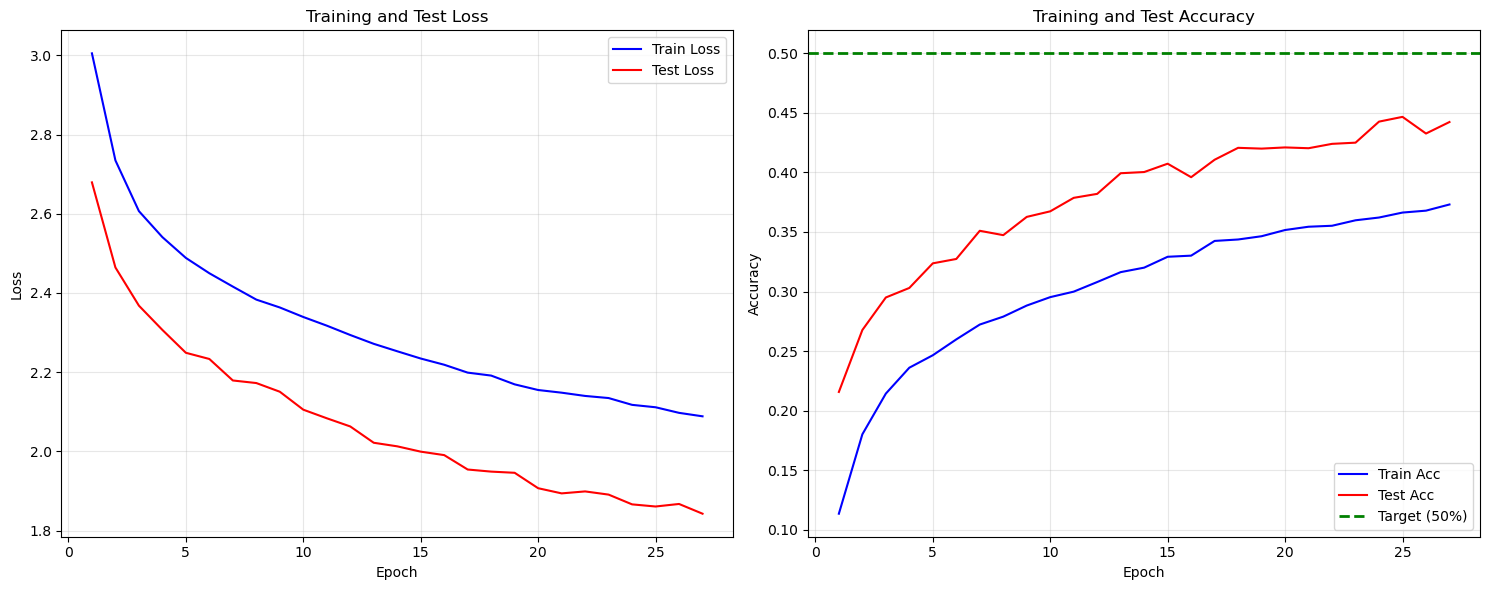

Epoch 27/30
Train → Loss: 2.0885 | Acc: 0.3731
Test  → Loss: 1.8426 | Acc: 0.4423
Best Test Acc: 0.4467
Learning Rate: 0.001000



  0%|          | 0/410 [00:00<?, ?it/s]

In [ ]:
train(model, opt, scheduler, batch_size=64, epochs=30)